In [2]:
import matplotlib
%matplotlib inline
import numpy
import os
# Import constants
import constant
# Create once the collection for this notebook
collection_id = None
import SEAScope.lib.utils
SEAScope.lib.utils.init_ids(10, 1000)
print('blablabla')

blablabla


## Load and select data
<span style="color:green">**Select the SSH on the day you want to compute geostrophic velocity on SEAScope**<br>
**Draw a polygon on SEASCope**<br>
**Click on the extract button on the polygon window**<br>
</span>

In [8]:
#Load data directly from viewer memory
from SEAScope.lib import get_extracted_data
extractions = get_extracted_data()
granule_id = None

**Load an old data data directly from a serialized extraction using the path printed on terminal <br>
(eg data_path = '/tmp/tmpcdemmhcb20170621TJun061498041719/seascope_extract.pyo')** <br>
Uncomment the following cell and fill data_path value

#from SEAScope.lib import load_pyo
#data_path = ''
#extractions = load_pyo(data_path)
## Print a list of path of extracted granules 
print('\n'.join(extractions.keys()))

**Print selected granules**

In [10]:
for k, data in enumerate(extractions.keys()):
    print('{} - {}'.format(k, os.path.basename(data)))
    print('\n'.join(['\t{}'.format(x) for x in extractions[data]['data']]))
list_name = []
list_date = []
for k, data in enumerate(extractions.keys()):
    list_name.append(os.path.basename(data))
    list_date.append(extractions[data]['meta']['start'])
k_u = sorted(range(len(list_date)), key=list_date.__getitem__)
print(k_u)    

0 - dt_global_allsat_phy_l4_20151224_20170110_idf_00.nc
	adt
[0]


<span style="color:red">**Choose number corresponding to ssh to compute geostrophic current**</span>

In [11]:
k_ssh = 0  # /!\ You may need to adapt this variable
granule_id = None

In [12]:
granule_uri =  next( v for i, v in enumerate(extractions.keys()) if i == k_ssh )
extraction = extractions[granule_uri]
data = extraction['data']['adt']
gcps = extraction['meta']['gcps']

## Play with the data
** Compute Geostrophic current: <br>
$ u = -\frac{g}{f} * \frac{d (ssh)}{d y}$<br>
$ v = \frac{g}{f} * \frac{d (ssh)}{d x}$**


In [13]:
# Get longitudes and latitudes from gcps
lon = [x['lon'] for x in gcps]
lat = [x['lat'] for x in gcps]

# Get Sea Level variable
ssh = data

# Reconstruct longitudes and latitudes
if (lon[-1] - lon[0]) > 180: 
    lon = (lon + 360) % 360
lon1D = numpy.linspace(lon[0], lon[-1], num=numpy.shape(ssh)[1])
lat1D = numpy.linspace(lat[0], lat[-1], num=numpy.shape(ssh)[0])
lon2D, lat2D = numpy.meshgrid(lon1D, lat1D)
from SEAScope.lib.utils import get_lonlat
lon2D, lat2D = get_lonlat(extraction, numpy.shape(ssh))

# Initialize null matrices
ugeo = numpy.full(numpy.shape(ssh), 0.)
vgeo = numpy.full(numpy.shape(ssh), 0.)

# Initial differential discretization number for a centered scheme
# usual value is 2
num_diff = 2
num_centered = int(num_diff/2)

# Compute g/f
goverf = constant.g/(constant.f0 * numpy.sin(numpy.deg2rad(lat2D)))

# Compute derivatives
dsshy = ssh[num_diff:, :] - ssh[:-num_diff, :]
dsshx = ssh[:, num_diff:] - ssh[:, :-num_diff]
dlonx = ((lon2D[:,num_diff:]-lon2D[:,:-num_diff])
        * numpy.cos(numpy.deg2rad(lat2D[:, num_centered:-num_centered])) * constant.degtom)
dlaty = (lat2D[num_diff:,:]-lat2D[:-num_diff,:]) * constant.degtom

# Compute geostrophic velocities
ugeo[num_centered:-num_centered, :] = -goverf[num_centered:-num_centered, :] * dsshy / dlaty
vgeo[:, num_centered:-num_centered] = goverf[:, num_centered:-num_centered] * dsshx / dlonx
# Mask invalid values
ugeo = numpy.ma.array(ugeo, mask=(ssh.mask  | (abs(ugeo)>10)))
vgeo = numpy.ma.array(vgeo, mask=(ssh.mask| (abs(vgeo)>10) ))

**Plot variables** <br>
<span style="color:red"> **You can try to plot ugeo (zonal componant), vgeo (meridional componant), the velocity norm, the ssh ... **</span>

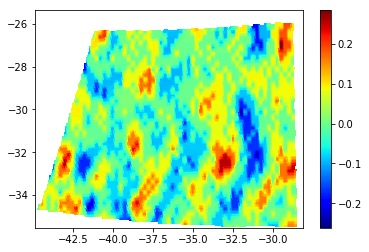

In [14]:
matplotlib.pyplot.pcolormesh(lon2D, lat2D, vgeo, cmap='jet')
matplotlib.pyplot.colorbar()  

## Export velocity to SEAScope

In [15]:
import json
import datetime
import numpy
import seascope_export
import SEAScope.lib.utils
from SEAScope.lib.utils import create_collection, create_variable
from SEAScope.lib.utils import create_granule, set_field

**Define Collection:** <br>
** A granule has to belong to a collection **<br>
<span style="color:red"> **Enter a name for the collection (collection_name)**</span>

In [16]:
if collection_id is None:
    # Collection
    collection_name = 'User - Geostrophic current'
    # Create collection
    collection_id, collection = create_collection(collection_name)
print(collection_id)

10


**Upload granule to SEAScope: <br>
Define shell of granule, create granule <br>
The granule will contain each matrix of modified data as what we call a "field"<br>**
<span style="color:red">** Enter a name for each field (field_name_u and field_name_v) **</span></br>
**Upload collection and granule to SEAScope**

In [17]:
# Create shell of Granule (where and when granule will appear)
#Start time of granule 
dtstart = extraction['meta']['start']
#End time of granule 
dtstop = extraction['meta']['stop']
# Create granule
if granule_id is None:
    granule_id, granule = create_granule(collection_id, gcps, dtstart, dtstop)

# Set variables
# Enter a name for each variable field
field_name_u = 'u_geo'
field_name_v = 'v_geo'
set_field(granule, field_name_u, ugeo)
set_field(granule, field_name_v, vgeo)   

#Upload collection and granule to SEAScope
#Upload to SEAScope
seascope_export.upload_granule(collection, granule)

1
1


**Telling SEAScope what to display: <br>
 The next step is variables definition. A variable may be composed of
one or two fields (in which case they are considered to be meridional and
zonal components of a vector).** <br>
**<span style="color:red"> Enter a name for each variable you want to display (variable_name_u,  variable_name_u, and variable_name_norm) </span>**</br>

In [18]:
# Create a variable for the horizontal component
variable_name_u = 'Zonal geostrophic current'
tmp = create_variable(collection, variable_name_u, [field_name_u])
if tmp is not None:
    u_variable = tmp
else: 
    print()
    raise Exception('See issues above')

# Create a variable for the vertical component 
variable_name_v =  'Meridional geostrophic current'
tmp = create_variable(collection,variable_name_v, [field_name_v])
if tmp is not None:
    v_variable = tmp
else: 
    print()
    raise Exception('See issues above')
    
# Create a variable for the complete vector
variable_name_norm = 'Norm of geostrophic current'
tmp = create_variable(collection, variable_name_norm,
                                  [field_name_u, field_name_v])
if tmp is not None:
    norm_variable = tmp
else: 
    print()
    raise Exception('See issues above')


# Upload variables to SEAScope
seascope_export.upload_variable(u_variable)
seascope_export.upload_variable(v_variable)
seascope_export.upload_variable(norm_variable)

** Telling SEAScope how to display variables: <br>
The rendering options are defined in the following cell. <br>
<span style="color:red"> You can play with min, max values, the colormap ... and check how the rendering changes on SEAScope </span>
**

In [19]:
from SEAScope.lib.utils import create_rendering_config

# Rendering configuration for the horizontal component
u_rcfg = u_variable['rendering']
u_rcfg['min'] = numpy.min(ugeo)
u_rcfg['max'] = numpy.max(ugeo)
u_rcfg['colormap'] = 'jet'
u_rcfg['zindex'] = 0.3

# Rendering configuration for the vertical component
v_rcfg = v_variable['rendering']
v_rcfg['min'] = numpy.min(vgeo)
v_rcfg['max'] = numpy.max(vgeo)
v_rcfg['colormap'] = 'jet'
v_rcfg['opacity'] = 0.3
v_rcfg['filterMode'] = 'BILINEAR'

# Rendering configuration for the complete vector
norm_rcfg = norm_variable['rendering']
norm_rcfg['min'] = 0.0
norm_rcfg['max'] = 2.5
norm_rcfg['colormap'] = 'jet'

# Upload to SEAScope
seascope_export.upload_config(u_rcfg)
seascope_export.upload_config(v_rcfg)
seascope_export.upload_config(norm_rcfg)

<span style="color:green">** Go back to SEAScope and visually compare your Geostrophic current with GlobCurrent geostrophic current. <br> play with range, colorbar, transparency ...**</span>